# 멀티 에이전트 네트워크

단일 에이전트는 일반적으로 단일 도메인 내에서 몇 가지 도구를 사용하여 효과적으로 작동할 수 있지만, `gpt-4`와 같은 강력한 모델을 사용하더라도 많은 도구를 사용하는 데는 덜 효과적일 수 있습니다.

복잡한 작업에 접근하는 한 가지 방법은 "분할 정복"(divide-and-conquer) 방식입니다. 각 작업 또는 도메인에 대해 특화된 에이전트를 만들고 작업을 올바른 "전문가"에게 전달합니다. 이는 [멀티 에이전트 네트워크](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network) 아키텍처의 예입니다.
 



이 에이전트 아키텍처는 논문 [AutoGen: 멀티 에이전트 대화를 통한 차세대 LLM 애플리케이션 지원](https://arxiv.org/abs/2308.08155)에서 영감을 받아 LangGraph를 사용하여 이를 수행하는 한 가지 방법을 보여줍니다.

결과 그래프는 다음 다이어그램과 유사합니다.

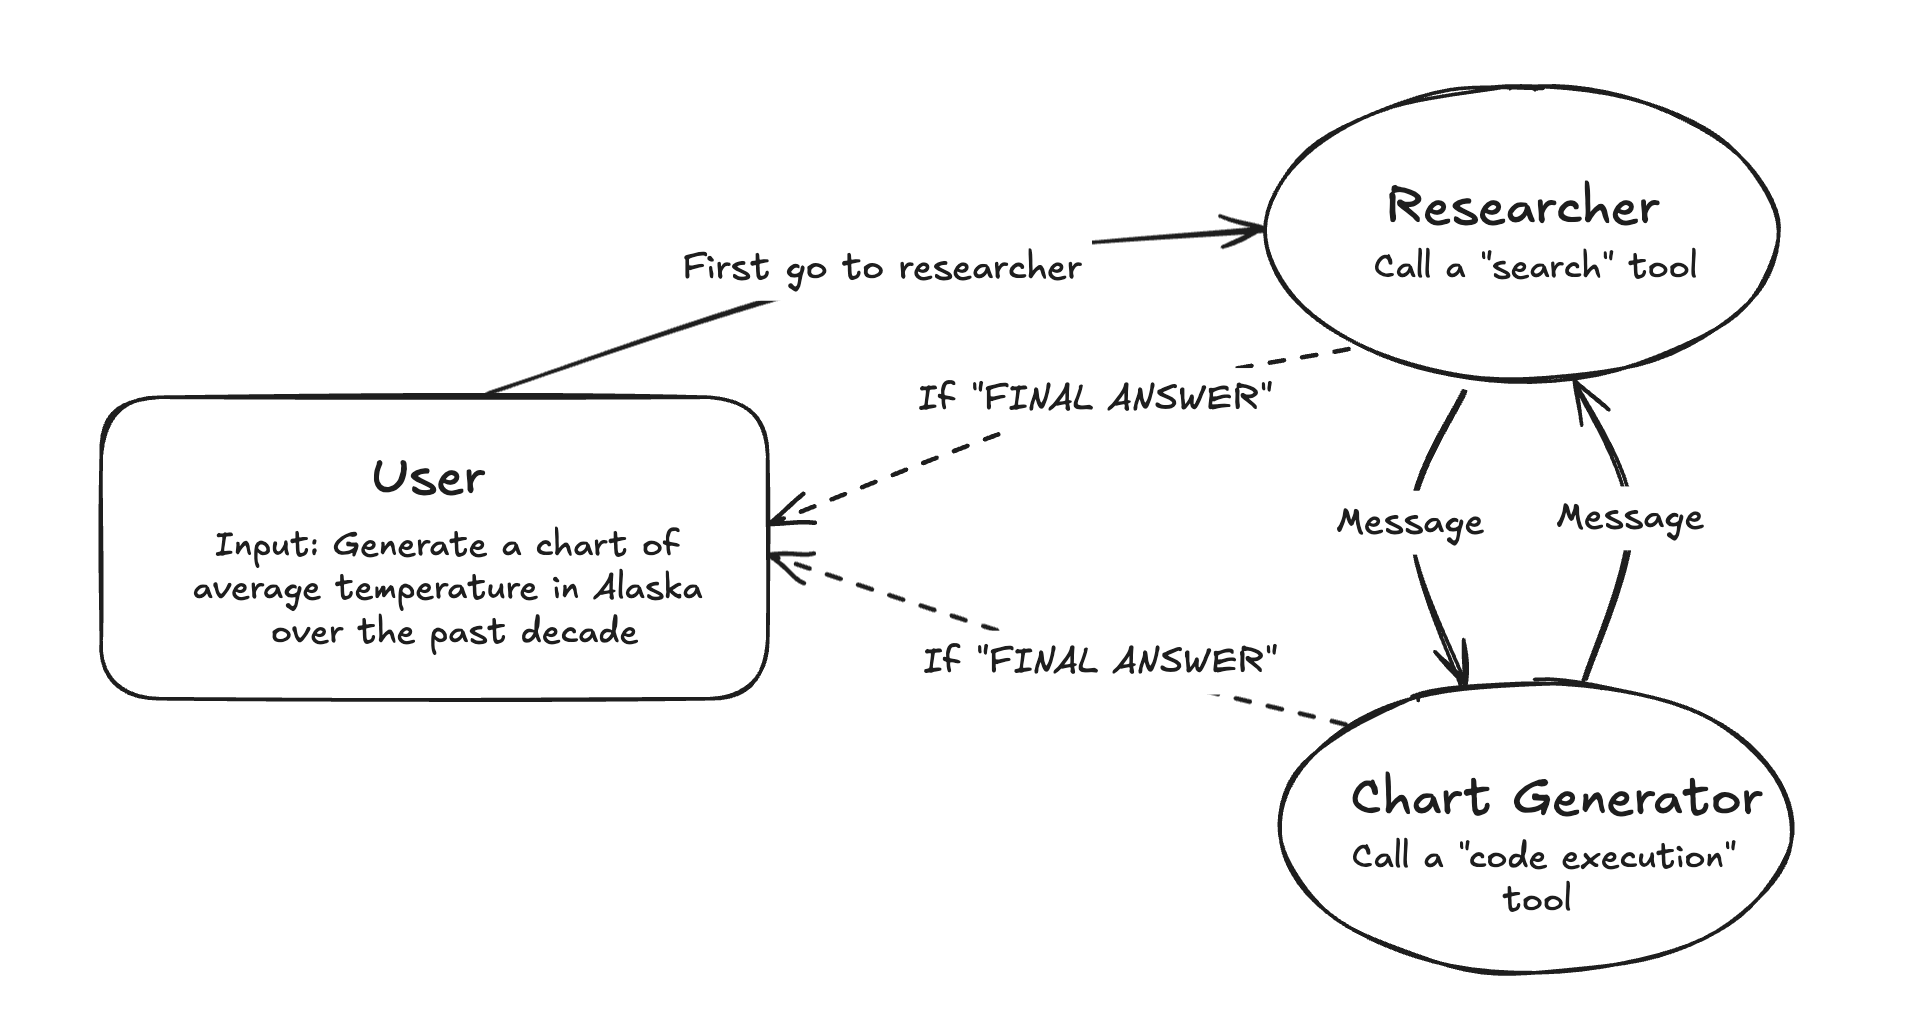

시작하기 전에 간단히 언급하자면, 이 글에서 나오는 예제는 LangGraph에서 특정 디자인 패턴을 구현하는 방법을 보여주기 위해 설계되었습니다. 패턴이 요구 사항에 적합하다면 최상의 성능을 위해 문서의 다른 곳에 설명된 다른 기본 패턴과 결합하는 것이 좋습니다.

## 설정

먼저 필요한 패키지를 설치하고 API 키를 설정해 보겠습니다.

In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_anthropic langchain_experimental matplotlib langgraph langchain_google_vertexai

In [5]:
!pip install -qU langchain-teddynote

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.29.0 requires protobuf<6.0,>=5.0, but you have protobuf 4.25.6 which is incompatible.
grpcio-status 1.64.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.
starter-app-sample 0.2.0 requires pydantic==2.9.2, but you have pydantic 2.10.6 which is incompatible.
starter-app-sample 0.2.0 requires pypdf<5.0.0,>=4.3.1, but you have pypdf 5.1.0 which is incompatible.
starter-app-sample 0.2.0 requires traceloop-sdk<0.34.0,>=0.33.12, but you have traceloop-sdk 0.36.0 which is incompatible.


In [6]:

from langchain_teddynote import logging

In [1]:
import getpass
import os
import dotenv

dotenv.load_dotenv()

# def _set_if_undefined(var: str):
#     if not os.environ.get(var):
        # os.environ[var] = getpass.getpass(f"Please provide your {var}")
# 

# _set_if_undefined("ANTHROPIC_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## 도구 정의

앞으로 에이전트가 사용할 몇 가지 도구를 정의하겠습니다.

In [2]:
# typing 모듈에서 Annotated를 임포트합니다.
# typing 모듈에서 Annotated를 임포트합니다. Annotated는 변수에 메타데이터를 추가하는 데 사용됩니다.
from typing import Annotated

# langchain_community.tools.tavily_search에서 웹 검색을 위해 TavilySearchResults를 임포트합니다.
from langchain_community.tools.tavily_search import TavilySearchResults
# langchain_core.tools에서 tool을 임포트합니다.
from langchain_core.tools import tool
# langchain_experimental.utilities에서 파이선 코드 실행을 위해 PythonREPL을 임포트합니다.
from langchain_experimental.utilities import PythonREPL

# TavilySearchResults 도구를 초기화합니다. 최대 검색 결과 수는 5입니다.
tavily_tool = TavilySearchResults(max_results=5)

# 경고: 이 코드는 로컬에서 코드를 실행하므로 샌드박스 환경이 아닌 경우 안전하지 않을 수 있습니다.

# PythonREPL 도구를 초기화합니다.
repl = PythonREPL()

# python_repl_tool 데코레이터를 사용하여 함수를 Langchain 도구로 등록합니다.
@tool
# python_repl_tool 함수를 정의합니다. 이 함수는 Python 코드를 실행하고 결과를 반환합니다.
def python_repl_tool(
    # code 인수는 실행할 Python 코드입니다. Annotated를 사용하여 코드에 대한 설명을 제공합니다.
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """파이썬 코드를 실행하는 데 사용합니다. 값의 출력을 보려면 `print(...)`를 사용하여 출력해야 합니다. 이는 사용자에게 표시됩니다."""
    try:
        # repl.run() 메서드를 사용하여 코드를 실행하고 결과를 가져옵니다.
        result = repl.run(code)
    # 코드 실행 중 오류가 발생하면 예외를 처리합니다.
    except BaseException as e:
        # 오류 메시지를 반환합니다.
        return f"Failed to execute. Error: {repr(e)}"
    # 실행 결과를 문자열로 formatting합니다.
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    # 실행 결과와 완료 메시지를 반환합니다.
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## 그래프 생성
이제 도구를 정의하고 몇 가지 헬퍼 함수를 만들었으므로, 아래에서 개별 에이전트를 생성하고 LangGraph를 사용하여 서로 통신하는 방법을 알려줍니다.

### 에이전트 노드 정의

이제 노드를 정의해야 합니다.

먼저 각 에이전트에 대한 시스템 프롬프트를 생성하는 유틸리티를 만듭니다.

In [3]:
# research_agent와 research_agent의 시스템 프롬프트로 사용합니다.
def make_system_prompt(suffix: str) -> str:
    return (
        # "당신은 다른 어시스턴트와 협업하는 유용한 AI 어시스턴트입니다."
        # " 제공된 도구를 사용하여 질문에 대한 답변을 진행하십시오."
        # " 완전히 답변할 수 없더라도 괜찮습니다. 다른 도구를 가진 다른 어시스턴트가 당신이 멈춘 부분에서 도움을 줄 것입니다. 
        # 진행하기 위해 할 수 있는 것을 실행하십시오."
        # " 당신이나 다른 어시스턴트가 최종 답변(FINAL ANSWER) 또는 결과물을 가지고 있다면,"
        # " 팀이 중단해야 하는 것을 알 수 있도록 응답 앞에 최종 답변(FINAL ANSWER)을 붙이십시오."
        # f"\n{suffix}"
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

<details>
    <summary>Command 설명</summary>
`Command[Literal["chart_generator", END]]`는 Langchain과 LangGraph에서 사용되는 타입 힌트이며, 특정 노드에서 반환될 수 있는 명령의 유형을 나타냅니다. 좀 더 자세히 설명하면 다음과 같습니다.

*   **`Command`**: LangGraph에서 그래프 내의 다음 단계를 결정하는 데 사용되는 객체입니다.  이 객체는 업데이트할 상태와 이동할 다음 노드를 지정합니다.
*   **`Literal["chart_generator", END]`**: `typing` 모듈에서 가져온 `Literal`은 문자열 리터럴의 집합을 나타내는 데 사용됩니다.  이 경우, 허용되는 값은 `"chart_generator"` 또는 `"END"`입니다.
    *   `"chart_generator"`: 그래프가 `chart_generator` 노드로 이동해야 함을 나타냅니다.
    *   `"END"`: 그래프 실행이 종료되어야 함을 나타냅니다.

따라서 `Command[Literal["chart_generator", END]]`는 함수가 `chart_generator` 노드로 이동하거나 그래프 실행을 종료하도록 지시하는 `Command` 객체를 반환해야 함을 의미합니다.  이것은 `research_node`가 수행한 작업에 따라 다음에 어떤 노드를 실행할지 결정한다는 것을 나타냅니다.

예를 들어, `research_node`가 작업을 완료하고 차트 생성기로 진행해야 한다고 판단하면 `goto`는 `"chart_generator"`가 됩니다.  작업이 완료되면 `goto`는 `"END"`가 됩니다.
</details>

In [4]:
# 필요한 라이브러리들을 import합니다.
from typing import Literal

# 메시지 관련 클래스를 import합니다.
from langchain_core.messages import BaseMessage, HumanMessage
# from langchain_anthropic import ChatAnthropic
# Google Vertex AI의 ChatVertexAI 모델을 사용하기 위한 import
from langchain_google_vertexai import ChatVertexAI
# LangGraph에서 미리 만들어진 에이전트 생성 함수를 import합니다.
from langgraph.prebuilt import create_react_agent
# LangGraph의 그래프 관련 클래스와 종료 조건을 import합니다.
from langgraph.graph import MessagesState, END
# LangGraph의 Command 타입을 import합니다.
from langgraph.types import Command


# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
llm = ChatVertexAI(model="gemini-2.0-flash-001")


# 다음 노드를 결정하는 함수를 정의합니다.
def get_next_node(last_message: BaseMessage, goto: str):
    # 마지막 메시지에 "FINAL ANSWER"가 포함되어 있으면 종료합니다.
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    # 그렇지 않으면 지정된 노드로 이동합니다.
    return goto


# Research agent와 node를 정의합니다.
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


# research_node 함수를 정의합니다.
def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    # research_agent를 호출하여 결과를 얻습니다.
    result = research_agent.invoke(state)
    # 다음 노드를 결정합니다.
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    # Command 객체를 반환합니다.
    return Command(
        update={
            # 리서치 에이전트의 내부 메시지 기록을 다른 에이전트와 공유합니다.
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent와 node를 정의합니다.
# chart_agent를 생성합니다.
chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


# chart_node 함수를 정의합니다.
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    # chart_agent를 호출하여 결과를 얻습니다.
    result = chart_agent.invoke(state)
    # 다음 노드를 결정합니다.
    goto = get_next_node(result["messages"][-1], "researcher")
    # 일부 제공자는 입력 메시지 목록의 마지막 위치에
    # AI 메시지를 허용하지 않으므로 Human 메시지로 래핑합니다.
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    # Command 객체를 반환합니다.
    return Command(
        update={
            # 차트 에이전트의 내부 메시지 기록을 다른 에이전트와 공유합니다.
            "messages": result["messages"],
        },
        goto=goto,
    )

### 그래프 정의
이제 모든 것을 합쳐서 그래프를 정의할 수 있습니다!

In [8]:
# StateGraph와 START를 langgraph.graph에서 임포트합니다.
from langgraph.graph import StateGraph, START

# MessagesState를 사용하여 StateGraph를 초기화합니다.
workflow = StateGraph(MessagesState)
# "researcher" 노드를 workflow에 추가하고 research_node 함수를 연결합니다.
workflow.add_node("researcher", research_node)
# "chart_generator" 노드를 workflow에 추가하고 chart_node 함수를 연결합니다.
workflow.add_node("chart_generator", chart_node)

# START 노드에서 "researcher" 노드로 가는 엣지를 추가합니다.
workflow.add_edge(START, "researcher")
# workflow를 컴파일하여 실행 가능한 그래프를 생성합니다.
graph = workflow.compile()

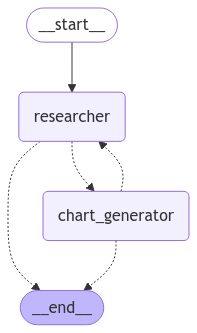

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

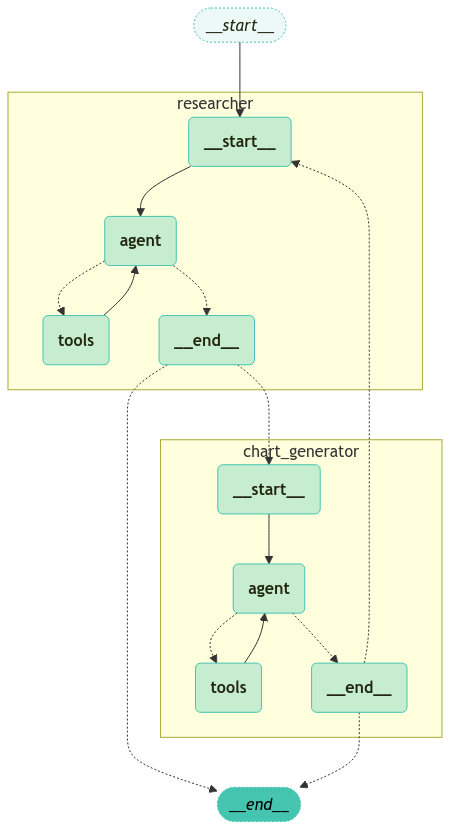

In [10]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph, xray=True)

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='6bb65e8b-c517-491f-bf81-0580d88c8041'),
                             AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "UK GDP past 5 years"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 180, 'candidates_token_count': 15, 'total_token_count': 195, 'prompt_tokens_details': [{'modality': 1, 'token_count': 180}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 15}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.047537815570831296}, id='run-2589715e-6115-4c4e-bf87-50681de04583-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP past 5 years'}, 'id': '7

Python REPL can execute arbitrary code. Use with caution.


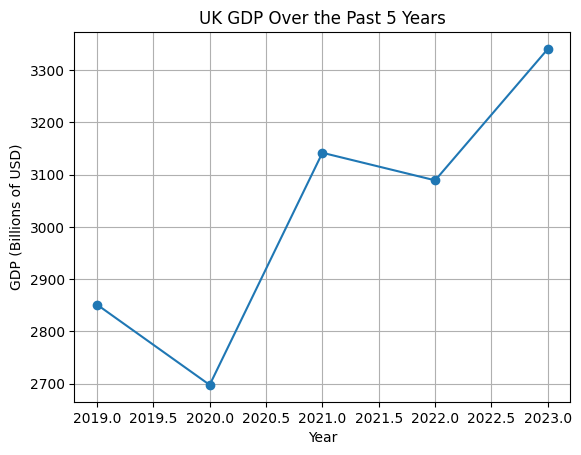

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='6bb65e8b-c517-491f-bf81-0580d88c8041'),
                                  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "UK GDP past 5 years"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 180, 'candidates_token_count': 15, 'total_token_count': 195, 'prompt_tokens_details': [{'modality': 1, 'token_count': 180}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 15}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.047537815570831296}, id='run-2589715e-6115-4c4e-bf87-50681de04583-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP past 5 years'}

In [11]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
import pprint
for s in events:
    pprint.pprint(s)
    print("----")


🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (55377af9-6b02-4136-ad0a-10462aaac698)
 Call ID: 55377af9-6b02-4136-ad0a-10462aaac698
  Args:
    query: UK GDP over the past 5 years

🔄 Node: tools in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.macrotrends.net/global-metrics/countries/gbr/united-kingdom/gdp-growth-rate", "content": "U.K. GDP Growth Rate 1961-2025 | MacroTrends U.K. GDP Growth Rate 1961-2025 GDP Growth Rate Annual percentage growth rate of GDP at market prices based on constant local currency. U.K. gdp growth rate for 2023 was 0.10%, a 4.24% decline from 2022. U.K. gdp growth rate for 2022 was 4.35%, a 4.33% decline from 2021. U.K. gdp growth rate for 2021 was

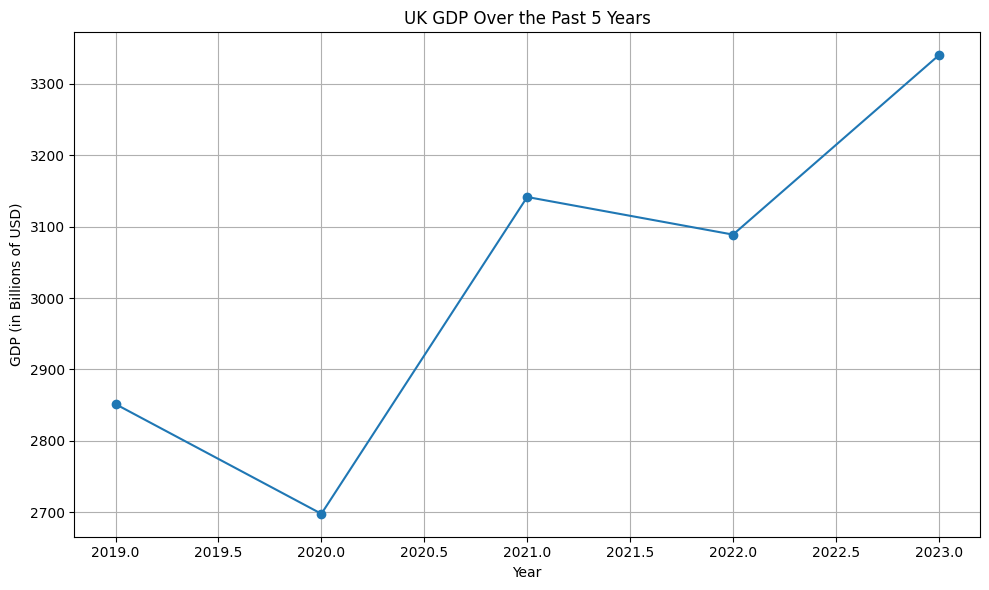


🔄 Node: tools in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: python_repl_tool

Successfully executed:
```python

import matplotlib.pyplot as plt

years = [2019, 2020, 2021, 2022, 2023]
gdp = [2851.41, 2697.81, 3141.51, 3088.84, 3340.03]

plt.figure(figsize=(10, 6))
plt.plot(years, gdp, marker='o', linestyle='-')
plt.title('UK GDP Over the Past 5 Years')
plt.xlabel('Year')
plt.ylabel('GDP (in Billions of USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

```
Stdout: 
🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  python_repl_tool (b23252d4-e543-4086-bf32-f80e3592ead6)
 Call ID: b23252d4-e543-4086-bf32-f80e3592ead6
  Args:
    code: 
import matplotlib.pyplot as plt

years = [2019, 2020, 2021, 2022, 2023]
gdp = [2851.41, 2697.81, 3141.51, 3

In [14]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})


inputs ={
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    }
    
# inputs = {
#     "input": "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점을 설명해줘"
# }

invoke_graph(graph, inputs, config)